# Disaster tweet Project

Analysis disaster tweet for Jedha certification. #block4

In [2]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from module import helper
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import layers
import keras_tuner as kt
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from keras.layers import *
from keras.callbacks import *

import transformers
from transformers import AutoConfig, AutoModel
from transformers import AutoTokenizer, TFAutoModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer

from wordcloud import WordCloud,STOPWORDS
from IPython.display import HTML, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import plotly
import cufflinks
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected=True)
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import warnings
from string import punctuation
from collections import defaultdict
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [14]:
# sns 
color_palette = ['#265952', '#DFCEEB', '#DBDE2F', '#45201E', '#c7ac92', '#a44a3f']
sns.set_palette(sns.color_palette(color_palette))

## Load data

In [3]:
# dataset csv
train_csv = "../data/raw/train.csv"
test_csv = "../data/raw/test.csv"

# dataframes
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# display train
print("Train dataset")
display(train_df.sample(1))

# display test
print("Test dataset")
display(test_df.sample(1))

Train dataset


,id,keyword,location,text,target
6831,9783,trapped,Puerto Rico,Hollywood Movie About Trapped Miners Released ...,1


Test dataset


,id,keyword,location,text
1278,4196,drown,ID where potatoes grow,@GraysonDolan I'll fall and drown so I think I...


## EDA

In [7]:
## dataframe
disaster_df = train_df[["text", "target"]].copy()

#### Basic statistics

In [8]:
helper.general_statistics(disaster_df)

Number of rows : 7613

Display of dataset: 


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Basics statistics: 


,text,target
count,7613,7613.00000
unique,7503,NaN
top,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,10,NaN
mean,NaN,0.42966
std,NaN,0.49506
min,NaN,0.00000
25%,NaN,0.00000
50%,NaN,0.00000
75%,NaN,1.00000



General information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


None


Percentage of missing values: 


text      0.0
target    0.0
dtype: float64

In [9]:
disaster_df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


#### Graph

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Counts for disasters and non disasters tweets')

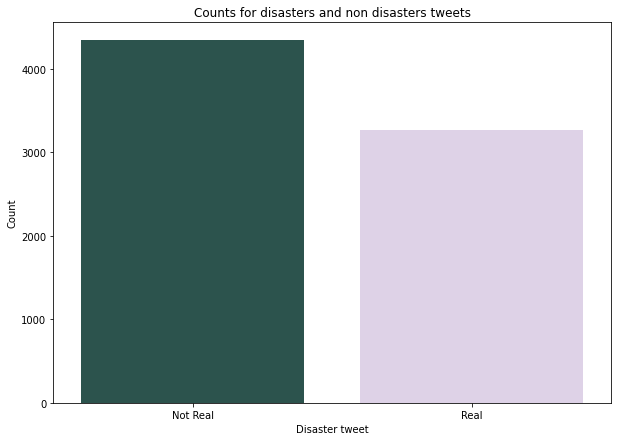

In [22]:
# number of plot
disaster_count_df = pd.DataFrame(disaster_df.groupby(["target"]).size()).reset_index()
disaster_count_df = disaster_count_df.rename(columns={0: "Count", 
                                            "target" : "Disaster tweet"})
disaster_count_df["Disaster tweet"] = disaster_count_df["Disaster tweet"].apply(lambda x : "Real" if x==1 else "Not Real")

# bar plot by conversion class
plt.figure(figsize=(10,7))
ax = sns.barplot(x="Disaster tweet", y="Count", data=disaster_count_df);
plt.title("Counts for disasters and non disasters tweets")
plt.show()

In [30]:
# stop words in dataset
## corpus : collection of texts
def create_corpus(df, target):
    """ create corpus.
    """
    corpus = []
    for i in df[df['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

## stop words : most common words in a language.
def count_stopwords(df, func, target):
    """ analyse stop words.
    """
    df_stopwords = pd.DataFrame(columns=["stop_words", "count"])

    corpus = func(df, target)
    dic = defaultdict(int)

    for word in corpus:
        dic[word] += 1

    top = sorted(dic.items(), key = lambda x: x[1], reverse=True)[:10]
    x_items,y_values = zip(*top)

    # fill dataframe
    df_stopwords["stop_words"] = x_items
    df_stopwords["count"] = y_values
    
    # sort values
    df_stopwords = df_stopwords.sort_values(by=["count"])

    return df_stopwords

#analyzing stopwords for 0 and 1 target labels
df_stopwords_0 = count_stopwords(disaster_df, create_corpus, 0)
print("Stop words for Non disaster target")
display(df_stopwords_0)

df_stopwords_1 = count_stopwords(disaster_df, create_corpus, 1)
print("Stop words for disaster target")
display(df_stopwords_1)

Stop words for Non disaster target


,stop_words,count
9,for,452
8,is,512
7,you,529
6,in,720
5,of,834
4,and,840
3,I,938
2,to,1099
1,a,1115
0,the,1524


Stop words for disaster target


,stop_words,count
9,is,302
8,for,368
7,on,386
6,-,389
5,and,462
4,to,706
3,a,730
2,of,888
1,in,1037
0,the,1051
